# AutoML

This notebook is part of the ML Challenges for Streaming Data Hands-On Tutorial and contains some basics for autoML using CapyMOA.
* Test example of autoML
* How to use CapyMOA for autoML
---

### CapyMOA 

* More information about CapyMOA can be found in: [https://github.com/adaptive-machine-learning/CapyMOA](https://github.com/adaptive-machine-learning/CapyMOA)

* _If you find CapyMOA useful, considering starring the project and joining the Discord channel!_

* **ECML 2024 tutorial ([homepage](https://heymarco.github.io/ecml24-streamingchallenges/))** by [Heitor Murilo Gomes](https://heitorgomes.com/), [Marco Heyden](https://heymarco.github.io/) and [Maroua Bahri](https://sites.google.com/site/bahrimarouaa/home). Vilnius, Lithuania (09/09/2024).

**Code examples are based on CapyMOA v0.7.0 as of 13/08/2024**


### Build your own pipeline
Either you will create you own autoML solution or use existing autoML ones, you need to undrestand the data and the pipeline that you are going to create/use 
* Data preprocessing
* Feature preprocessing
* Select the method(s) that will be used and train the model(s)
* If you are creating your automated method, choose the hyperparameter optimization method to use

<p align="center">
  <img src="./images/autoMLpipeline.png" alt="alt text" width="600"/>
</p>

### Example

<p align="center">
  <img src="./images//autoMLpipelineExample.png" alt="alt text" width="600"/>
</p>


### Model Selection
* Select the best performing model among four state-of-the-art online learning models (HT, KNN, ARF, SRP, NB) by evaluating their learning performance

In [1]:
from capymoa.datasets import Electricity
from capymoa.evaluation import prequential_evaluation
from moa.streams import ConceptDriftStream
from capymoa.stream.drift import DriftStream
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.classifier import (
    HoeffdingTree,  
    HoeffdingAdaptiveTree,
    KNN,
    NaiveBayes,
    AdaptiveRandomForestClassifier, 
    StreamingRandomPatches
)
streaming_dataset = Electricity()
streaming_dataset_drift = DriftStream(moa_stream=ConceptDriftStream(), 
                               CLI='-s (generators.AgrawalGenerator -f 1) -d (ConceptDriftStream -s (generators.AgrawalGenerator -f 2) -d (ConceptDriftStream -s (generators.AgrawalGenerator -f 3) -d (generators.AgrawalGenerator -f 4) -p 30000 -w 0) -p 20000 -w 0) -p 10000 -w 0')

In [2]:
# Define a generic adaptive learning function
def stream_learning_model_selection(model_list, window_size, max_instances):
    acc_b = 0 # The best accuracy score
    all_results = {}
    for model in model_list:
        results = prequential_evaluation(
            stream=streaming_dataset,
            learner=model,
            window_size=window_size,
            max_instances=max_instances
        )
        all_results[model] = results
        if results.cumulative.accuracy()>acc_b:
            acc_b = results.cumulative.accuracy()
            model_b = model
            
    print(f"{model_b} is selected as the best learner as it has the highest accuracy of: {results.cumulative.accuracy()} and wallclock: {results.wallclock()}")  
    return all_results


StreamingRandomPatches is selected as the best learner as it has the highest accuracy of: 80.44 and wallclock: 0.011214017868041992


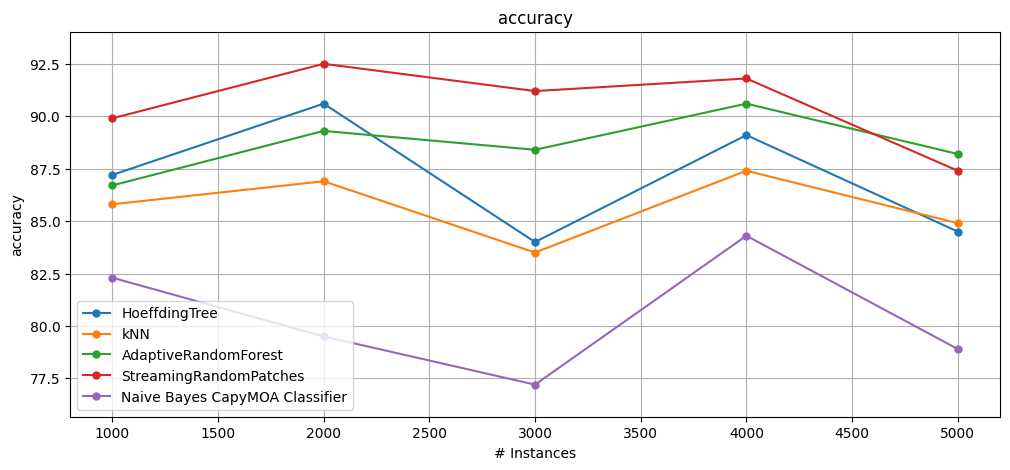

In [3]:
# Code to select the best performing model
ht = HoeffdingTree(schema=streaming_dataset.get_schema())
knn = KNN(schema=streaming_dataset.get_schema())
arf = AdaptiveRandomForestClassifier(schema=streaming_dataset.get_schema(), ensemble_size=5)
srp = StreamingRandomPatches(schema=streaming_dataset.get_schema(), ensemble_size=5)
nb = NaiveBayes(schema=streaming_dataset.get_schema())

model_list = [ht, knn, arf, srp, nb]

all_res = stream_learning_model_selection(model_list, 1000, 5000) 

plot_windowed_results(*all_res.values(), metric='accuracy')

### HPO and CapyMOA pipelines
* Use Random search to find the best configuration for a given learner (HT)
* Use a preprocessing technique
* Use the CapyMOA pipelines to create the combination of preprocessing, learner, and HPO  
* Compare against HT using the default hyperparameters

In [4]:
import numpy as np
from capymoa.stream.preprocessing import MOATransformer, RandomSearchClassifierPE, TransformerPipelineElement, ClassifierPipelineElement, ClassifierPipeline
from moa.streams.filters import NormalisationFilter

normalisation_transformer = MOATransformer(schema=streaming_dataset_drift.get_schema(), moa_filter=NormalisationFilter())

ht_pipeline_element = ClassifierPipelineElement(HoeffdingTree(streaming_dataset_drift.get_schema()))
ht_pipeline = ClassifierPipeline([TransformerPipelineElement(normalisation_transformer), ht_pipeline_element])

classifier_class = HoeffdingTree

hyperparameter_ranges = {
    "schema": [streaming_dataset.get_schema()],
    "grace_period": [1, 50, 100, 200, 500],
    "split_criterion": ["InfoGainSplitCriterion", "GiniSplitCriterion"],
    "confidence": [10.0 ** (-i) for i in range(1, 5)],
    "tie_threshold": [0.05, 0.03, 0.01, 0.001]
}

rng = np.random.default_rng(0)
n_combinations = 30

random_search_pe = RandomSearchClassifierPE(classifier_class, hyperparameter_ranges, n_combinations, rng)
rs_pipeline = ClassifierPipeline([TransformerPipelineElement(normalisation_transformer), random_search_pe])

PE(Transformer(NormalisationFilter)) | PE(HoeffdingTree) |  cumulative accuracy = 78.954802259887
PE(Transformer(NormalisationFilter)) | RandomSearch(HoeffdingTree) |   cumulative accuracy = 83.62243997175142


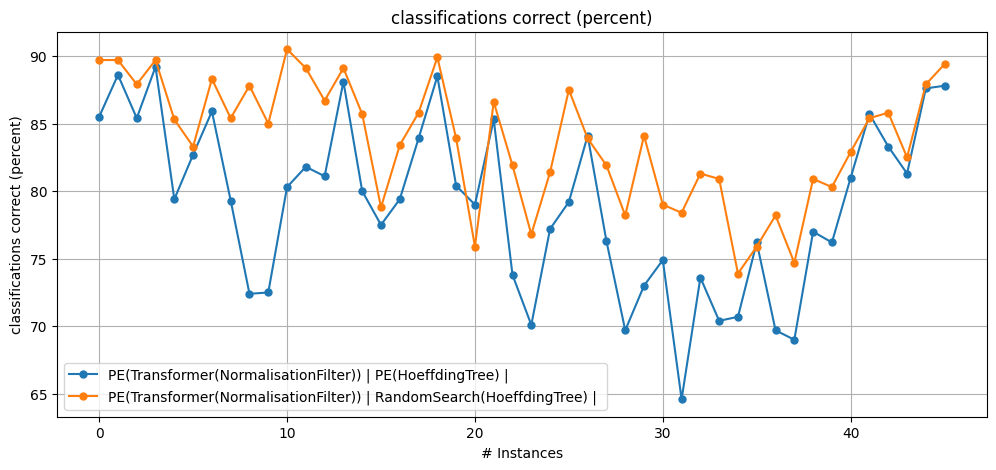

In [5]:
ht_results = prequential_evaluation(stream=streaming_dataset, learner=ht_pipeline, window_size=1000)
rs_results = prequential_evaluation(stream=streaming_dataset, learner=rs_pipeline, window_size=1000)

print(f"{ht_results['learner']} cumulative accuracy = {ht_results['cumulative'].accuracy()}")
print(f"{rs_results['learner']}  cumulative accuracy = {rs_results['cumulative'].accuracy()}")

plot_windowed_results(ht_results, rs_results, metric="classifications correct (percent)", figure_path=None)

## Automated Machine Learning for Data streams
### Example with AutoClass
#### Model selection and HPO

The following example shows how to use the AutoClass algorithm using CapyMOA. 
* AutoClass is configured using a json configuration file `configuration_json` and a list of classifiers `base_classifiers`
* The `configuration_json` is updatable, i.e., algorithms and their hyperparameter configurations can be changed
* AutoClass can also be configured with either a list of strings `base_classifiers` representing the MOA classifiers. This approach is only enticing for people that are very familiar with MOA. 
* In the example below, we also compare it against using the base classifiers individually


[HT] Cumulative accuracy = 85.615, wall-clock time: 0.1290428638458252
[HAT] Cumulative accuracy = 87.075, wall-clock time: 0.10480690002441406
[KNN] Cumulative accuracy = 85.47, wall-clock time: 0.9076211452484131
[NB] Cumulative accuracy = 77.235, wall-clock time: 0.05893301963806152
[AutoClass] Cumulative accuracy = 88.24, wall-clock time: 10.694916009902954


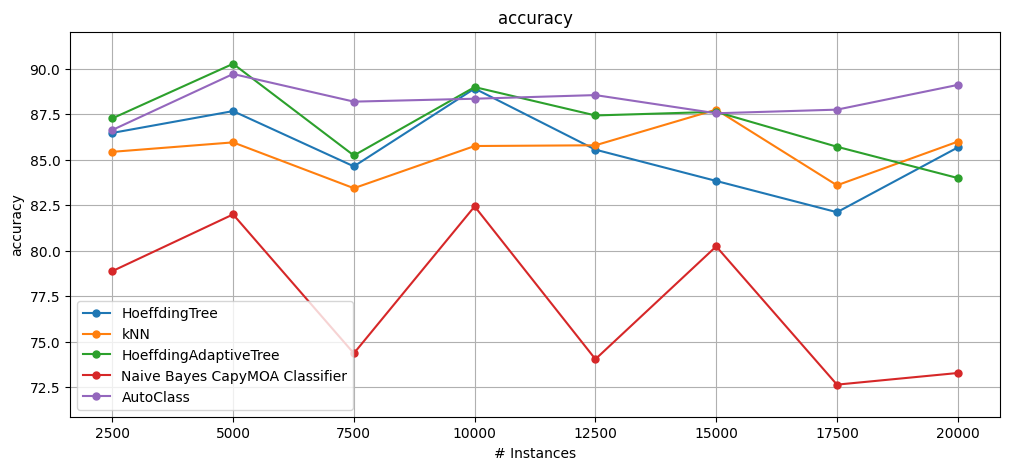

In [6]:
from capymoa.evaluation import prequential_evaluation 
from capymoa.automl import AutoClass

max_instances = 20000
window_size = 2500

ht = HoeffdingTree(schema=streaming_dataset.get_schema())
hat = HoeffdingAdaptiveTree(schema=streaming_dataset.get_schema())
knn = KNN(schema=streaming_dataset.get_schema())
nb = NaiveBayes(schema=streaming_dataset.get_schema())
autoclass = AutoClass(schema=streaming_dataset.get_schema(), 
                      configuration_json='./settings_autoclass.json', 
                      base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree])

results_ht = prequential_evaluation(stream=streaming_dataset, learner=ht, window_size=window_size, max_instances=max_instances)
results_hat = prequential_evaluation(stream=streaming_dataset, learner=hat, window_size=window_size, max_instances=max_instances)
results_knn = prequential_evaluation(stream=streaming_dataset, learner=knn, window_size=window_size, max_instances=max_instances)
results_nb = prequential_evaluation(stream=streaming_dataset, learner=nb, window_size=window_size, max_instances=max_instances)
results_autoclass = prequential_evaluation(stream=streaming_dataset, learner=autoclass, window_size=window_size, max_instances=max_instances)

print(f"[HT] Cumulative accuracy = {results_ht.accuracy()}, wall-clock time: {results_ht.wallclock()}")
print(f"[HAT] Cumulative accuracy = {results_hat.accuracy()}, wall-clock time: {results_hat.wallclock()}")
print(f"[KNN] Cumulative accuracy = {results_knn.accuracy()}, wall-clock time: {results_knn.wallclock()}")
print(f"[NB] Cumulative accuracy = {results_nb.accuracy()}, wall-clock time: {results_nb.wallclock()}")
print(f"[AutoClass] Cumulative accuracy = {results_autoclass.accuracy()}, wall-clock time: {results_autoclass.wallclock()}")
plot_windowed_results(results_ht, results_knn, results_hat, results_nb, results_autoclass, metric='accuracy')

[HT] Cumulative accuracy = 78.82249999999999, wall-clock time: 0.09333992004394531
[HAT] Cumulative accuracy = 78.23750000000001, wall-clock time: 0.20276880264282227
[KNN] Cumulative accuracy = 67.14, wall-clock time: 2.718440055847168
[NB] Cumulative accuracy = 60.29, wall-clock time: 0.029617786407470703
[AutoClass] Cumulative accuracy = 85.1475, wall-clock time: 39.12403321266174


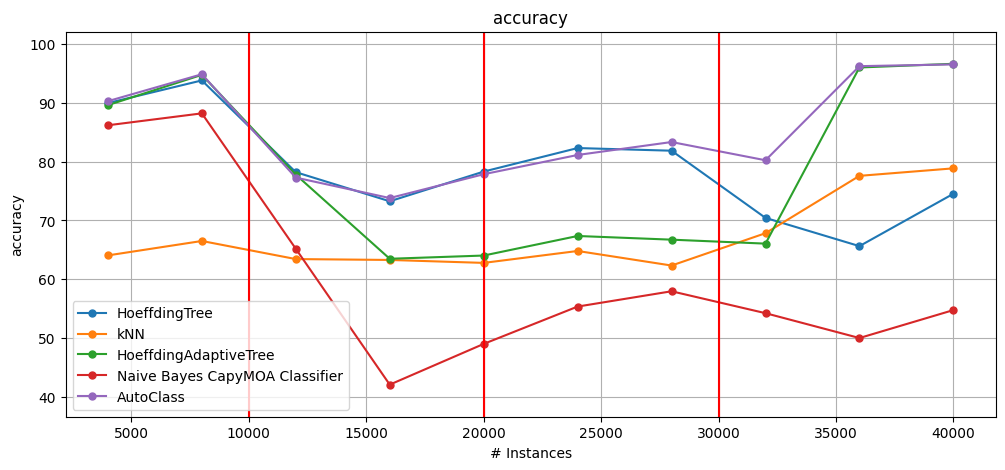

In [8]:
from capymoa.evaluation import prequential_evaluation 
from capymoa.automl import AutoClass

max_instances = 40000
window_size = 4000

ht = HoeffdingTree(schema=streaming_dataset_drift.get_schema())
hat = HoeffdingAdaptiveTree(schema=streaming_dataset_drift.get_schema())
knn = KNN(schema=streaming_dataset_drift.get_schema())
nb = NaiveBayes(schema=streaming_dataset_drift.get_schema())
autoclass = AutoClass(schema=streaming_dataset_drift.get_schema(), 
                      configuration_json='./settings_autoclass.json', 
                      base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree])

results_ht = prequential_evaluation(stream=streaming_dataset_drift, learner=ht, window_size=window_size, max_instances=max_instances)
results_hat = prequential_evaluation(stream=streaming_dataset_drift, learner=hat, window_size=window_size, max_instances=max_instances)
results_knn = prequential_evaluation(stream=streaming_dataset_drift, learner=knn, window_size=window_size, max_instances=max_instances)
results_nb = prequential_evaluation(stream=streaming_dataset_drift, learner=nb, window_size=window_size, max_instances=max_instances)
results_autoclass = prequential_evaluation(stream=streaming_dataset_drift, learner=autoclass, window_size=window_size, max_instances=max_instances)

print(f"[HT] Cumulative accuracy = {results_ht.accuracy()}, wall-clock time: {results_ht.wallclock()}")
print(f"[HAT] Cumulative accuracy = {results_hat.accuracy()}, wall-clock time: {results_hat.wallclock()}")
print(f"[KNN] Cumulative accuracy = {results_knn.accuracy()}, wall-clock time: {results_knn.wallclock()}")
print(f"[NB] Cumulative accuracy = {results_nb.accuracy()}, wall-clock time: {results_nb.wallclock()}")
print(f"[AutoClass] Cumulative accuracy = {results_autoclass.accuracy()}, wall-clock time: {results_autoclass.wallclock()}")
plot_windowed_results(results_ht, results_knn, results_hat, results_nb, results_autoclass, metric='accuracy')

#### AutoML for everyone in 3 lines of code !! 

In [9]:
autoclass = AutoClass(schema=streaming_dataset_drift.get_schema(), 
                      configuration_json='./settings_autoclass.json', 
                      base_classifiers=[KNN, HoeffdingAdaptiveTree, HoeffdingTree])
results_autoclass = prequential_evaluation(stream=streaming_dataset, learner=autoclass, window_size=window_size, max_instances=max_instances)

print(f"[AutoClass] Cumulative accuracy = {results_autoclass.accuracy()}, wall-clock time: {results_autoclass.wallclock()}")

[AutoClass] Cumulative accuracy = 86.29, wall-clock time: 36.948010206222534
